# Titanic - ML model
---

## Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.optimize as sciopt
import sklearn.ensemble
from sklearn import metrics
from sklearn import svm
import torch
import torch.nn as nn


## DAC (Data Acquisition)

In [2]:
trainData = pd.read_csv("assets/train.csv")
testData  = pd.read_csv("assets/test.csv")
# trainData.head()

def cleanData(dbx, dby):
    amNull = dbx.isnull().sum()
    amNull = list(amNull)
    idxAmNullMax = amNull.index(max(amNull))
    amNull_ = amNull[idxAmNullMax]

    Nan = True

    db_cleanX = pd.get_dummies(dbx).values
    db_cleanY = pd.get_dummies(dby).values

    while Nan:
        if amNull_ == 0:
            Nan = False
        else:
            idxListNan = np.argwhere(np.isnan(db_cleanX))

            # db_cleanX = np.delete(db_cleanX, idxListNan[0,0])
            # db_cleanY = np.delete(db_cleanY, idxListNan[0,0])
            db_cleanX = np.delete(db_cleanX, idxListNan[0,0], axis=0)
            db_cleanY = np.delete(db_cleanY, idxListNan[0,0], axis=0)
            amNull_ -= 1
    
    return db_cleanX, db_cleanY


## Model - Clean Data

In [3]:
features = ['Pclass', 'Sex', 'Age', "SibSp", 'Parch', 'Fare']
yTrain = trainData['Survived'][0::2]
yTest  = trainData['Survived'][1::2]
xTrain = trainData[features][0::2]
xTest  = trainData[features][1::2]


xTrainC, yTrainC = cleanData(xTrain, yTrain)
xTestC,  yTestC  = cleanData(xTest, yTest)

xTrain.shape

(446, 6)

## Model - Testing 

### PyTorch Models

In [15]:
data_keys = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']
x_list = [key for key in data_keys[2:]]
y_list = data_keys[1]

X_data = trainData[x_list]
Y_data = trainData[y_list]
X_data, Y_data = cleanData(X_data, Y_data)
X_data, Y_data = torch.from_numpy(X_data.astype(np.float32)), torch.from_numpy(Y_data.astype(np.float32))

print(f'X_data.shape: {X_data.shape}')
print(f'Y_data.shape: {Y_data.shape}')

X_train, X_test, Y_train, Y_test = sklearn.model_selection.train_test_split(X_data, Y_data, train_size=0.8)


# print(f'X_train.shape: {X_train.shape}')
# print(f'Y_train.shape: {Y_train.shape}')

# X_train, Y_train = torch.from_numpy(X_train.astype(np.float32)), torch.from_numpy(Y_train.astype(np.float32))
# X_test, Y_test   = torch.from_numpy(X_test.astype(np.float32)), torch.from_numpy(Y_test.astype(np.float32))

print(f'X_train.shape: {X_train.shape}')
print(f'Y_train.shape: {Y_train.shape}')
print(f'X_test.shape: {X_test.shape}')
print(f'Y_test.shape: {Y_test.shape}')


X_data.shape: torch.Size([714, 7])
Y_data.shape: torch.Size([714, 2])
X_train.shape: torch.Size([571, 7])
Y_train.shape: torch.Size([571, 2])
X_test.shape: torch.Size([143, 7])
Y_test.shape: torch.Size([143, 2])


In [18]:
from time import time

## model ##
class NeuralNet(nn.Module):
    def __init__(self, inp_size:int, hid_size:int, out_size:int) -> None:
        super(NeuralNet, self).__init__()
        self.l1   = nn.Linear(inp_size, hid_size)
        self.tanh = nn.Tanh()
        self.l2   = nn.Linear(hid_size, hid_size)
        self.l3   = nn.Linear(hid_size, out_size)

    def forward(self, x):
        out = self.l1(x)
        out = self.tanh(out)
        out = self.l2(out)
        out = self.tanh(out)
        out = self.l3(out)
        return out

print('Hyper-parameters:')
n_targets  = len(Y_train[0]); print(f'n_targets  = {n_targets }')
inp_size   = len(X_train[0]); print(f'inp_size   = {inp_size}')
hid_size   = 100; print(f'hid_size   = {hid_size}')
learn_rate = 0.002; print(f'learn_rate = {learn_rate}')

model_nn  = NeuralNet(inp_size, hid_size, n_targets)
criterion = nn.CrossEntropyLoss()
optimiser = torch.optim.Adam(model_nn.parameters(), lr=learn_rate)


num_epoch  = 20000; print(f'num_epoch  = {num_epoch}\n')

## training loop ##
train_samples = len(X_train)
ts = time()
for epoch in range(num_epoch):
    # for sample in range(train_samples):
    x_sample = X_train#[sample]
    y_sample = Y_train#[sample]

    ## forward ##
    output = model_nn(x_sample)
    loss   = criterion(output, y_sample)

    ## backward ##
    optimiser.zero_grad()
    loss.backward()
    optimiser.step()
    
    if (epoch+1)%2000 == 0:
        print(f'epoch: {epoch+1}/{num_epoch}, loss={loss.item():5f}')


t_train = time()-ts
ts = time()
## testing loop ##
test_samples = len(Y_test)
with torch.no_grad():
    n_correct = 0
    n_samples = 0

    for i in range(test_samples):
        output = model_nn(X_test[i])
        _, predictions = torch.max(output, dim=0)
        _, actual      = torch.max(Y_test[i], dim=0)
        n_samples += 1
        n_correct += (predictions == actual).sum()

    
    acc = 100*n_correct/n_samples
    print(f'\nTesting Dataset\nacc = {acc:.5f}%')

t_test = time()-ts
ts = time()

## entire loop ##
test_samples = len(Y_data)
with torch.no_grad():
    n_correct = 0
    n_samples = 0

    for i in range(test_samples):
        output = model_nn(X_data[i])
        _, predictions = torch.max(output, dim=0)
        _, actual      = torch.max(Y_data[i], dim=0)
        n_samples += 1
        n_correct += (predictions == actual).sum()

    
    acc = 100*n_correct/n_samples
    print(f'\nEntire Dataset\nacc = {acc:.5f}%')

t_entire = time()-ts
print('\nTime:')
print(f'Training: {t_train:.3f}')
print(f'Testing: {t_test:.3f}')
print(f'Entire: {t_entire:.3f}')



## confusion matrix ##
# y_pred = model_nn()
# confMat = metrics.confusion_matrix(yTestC[:,1], y_pred)
# CM_disp = metrics.ConfusionMatrixDisplay(confusion_matrix=confMat, display_labels=[False, True])
# CM_disp.plot()
# plt.show()


Hyper-parameters:
n_targets  = 2
inp_size   = 7
hid_size   = 100
learn_rate = 0.002
num_epoch  = 20000

epoch: 2000/20000, loss=0.256233
epoch: 4000/20000, loss=0.218485
epoch: 6000/20000, loss=0.200816
epoch: 8000/20000, loss=0.189672
epoch: 10000/20000, loss=0.176653
epoch: 12000/20000, loss=0.150193
epoch: 14000/20000, loss=0.134274
epoch: 16000/20000, loss=0.121035
epoch: 18000/20000, loss=0.104713
epoch: 20000/20000, loss=0.094513

Testing Dataset
acc = 68.53147%

Entire Dataset
acc = 90.33614%

Time:
Training: 44.640
Testing: 0.017
Entire: 0.072


### PyTorch with k-fold validation

In [54]:
## data ##
data_keys = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']
x_list = [key for key in data_keys[2:]]
y_list = data_keys[1]

X_data = trainData[x_list]
Y_data = trainData[y_list]
X_data, Y_data = cleanData(X_data, Y_data)
X_data, Y_data = torch.from_numpy(X_data.astype(np.float32)), torch.from_numpy(Y_data.astype(np.float32))

## Split data ##
def k_fold_split_data(k_fold_amount:int, x_data, y_data):
    """
    Parameters
    ----------
    k_fold_amount : int
        The mount of validation batches.
    x_data : Any
        The predictor data set.
    y_data : Any
        The target data set.

    Returns
    -------
    data : dict
        {k_fold_i : [x_training], [x_validation], [y_training], [y_validation]}
    
    """
    from sklearn.model_selection import KFold
    
    ## get idx ##
    k_splitter = KFold(n_splits=k_fold_amount)
    data_idx   = {}
    data       = {}
    i = 1
    for train_idx, test_idx in k_splitter.split(x_data, y_data):
        # print(f"train: {train_idx} test: {test_idx}")
        set = [train_idx, test_idx]
        data_idx[f'k_fold_{i}'] = set
        i+=1

    for k in range(k_fold_amount):
        x_tra, y_tra = [], []
        x_val, y_val = [], []
        for idx in data_idx[f'k_fold_{k+1}'][0]:
            x_tra.append(x_data[idx])
            y_tra.append(y_data[idx])
        for idx in data_idx[f'k_fold_{k+1}'][1]:
            x_val.append(x_data[idx])
            y_val.append(y_data[idx])

        data[f'k_fold_{k+1}'] = [torch.stack(x_tra), torch.stack(x_val), torch.stack(y_tra), torch.stack(y_val)]
        # data[f'k_fold_{k+1}'] = [np.array(x_tra), np.array(x_val), np.array(y_tra), np.array(y_val)]

    return data

k_fold_amount = 6
X_Train, X_Val, Y_Train, Y_Val = sklearn.model_selection.train_test_split(X_data, Y_data, test_size=0.1)
data = k_fold_split_data(k_fold_amount, X_Train, Y_Train); print(f'data.keys amount: {k_fold_amount}') 
# type(data['k_fold_1'][0])
# # a = torch.stack(data['k_fold_1'][0])
# # type(a)

data.keys amount: 6


In [62]:
## model ##
class NeuralNet(nn.Module):
    def __init__(self, inp_size:int, hid_size:int, out_size:int) -> None:
        super(NeuralNet, self).__init__()
        self.l1   = nn.Linear(inp_size, hid_size)
        self.tanh = nn.Tanh()
        self.l2   = nn.Linear(hid_size, hid_size)
        self.l3   = nn.Linear(hid_size, out_size)

    def forward(self, x):
        out = self.l1(x)
        out = self.tanh(out)
        out = self.l2(out)
        out = self.tanh(out)
        out = self.l3(out)
        return out

print('Hyper-parameters:')
hid_size   = 100; print(f'hid_size   = {hid_size}')
learn_rate = 0.002; print(f'learn_rate = {learn_rate}')
num_epoch  = 4000; print(f'num_epoch  = {num_epoch}\n')
n_targets  = len(Y_data[0]); print(f'n_targets  = {n_targets }')
inp_size   = len(X_data[0]); print(f'inp_size   = {inp_size}')

model_nn  = NeuralNet(inp_size, hid_size, n_targets)
criterion = nn.CrossEntropyLoss()
optimiser = torch.optim.Adam(model_nn.parameters(), lr=learn_rate)

loss_nn_list = []
epoch_nn_list = np.arange(1, (num_epoch)*5+1)

k_fold_res= {}
for k_fold in range(1, k_fold_amount+1):
    epoch_list = np.arange(1, num_epoch+1)
    loss_list  = []
    test_acc   = 0

    ## k_fold data ##
    x_train, x_val, y_train, y_val = data[f'k_fold_{k_fold}']
    # x_train, x_val, y_train, y_val = torch.from_numpy(x_train), torch.from_numpy(x_val), torch.from_numpy(y_train), torch.from_numpy(y_val)

    ## k_fold model ##
    model_k = NeuralNet(inp_size, hid_size, n_targets)
    criterion_k = nn.CrossEntropyLoss()
    optimiser_k = torch.optim.Adam(model_k.parameters(), lr=learn_rate)

    ## training loop ##
    for epoch in range(num_epoch):

        ## forward ##
        output_k  = model_k(x_train)
        output_nn = model_nn(x_train)
        loss_k    = criterion_k(output_k, y_train)
        loss_nn   = criterion(output_nn, y_train)

        ## backward ##
        optimiser_k.zero_grad()
        optimiser.zero_grad()
        loss_k.backward()
        loss_nn.backward()
        optimiser_k.step()
        optimiser.step()

        loss_list.append(loss_k.item())
        loss_nn_list.append(loss_nn.item())

    ## testing loop ##
    test_samples = len(y_val)
    with torch.no_grad():
        n_correct = 0
        n_samples = 0

        for i in range(test_samples):
            output = model_k(x_val[i])
            _, predictions = torch.max(output, dim=0)
            _, actual      = torch.max(y_val[i], dim=0)
            n_samples += 1
            n_correct += (predictions == actual).sum()

        
        test_acc = 100*n_correct/n_samples
        
        print(f'\nValidation Dataset for k_fold_{k_fold}\nacc = {test_acc:.5f}%')

    ## save data ##
    k_fold_res[f'k_fold_{k_fold}'] = [epoch_list, loss_list, test_acc]



Hyper-parameters:
hid_size   = 100
learn_rate = 0.002
num_epoch  = 4000

n_targets  = 2
inp_size   = 7

Validation Dataset for k_fold_1
acc = 71.96262%

Validation Dataset for k_fold_2
acc = 64.48598%

Validation Dataset for k_fold_3
acc = 66.35514%

Validation Dataset for k_fold_4
acc = 58.87851%

Validation Dataset for k_fold_5
acc = 73.83178%

Validation Dataset for k_fold_6
acc = 67.28972%


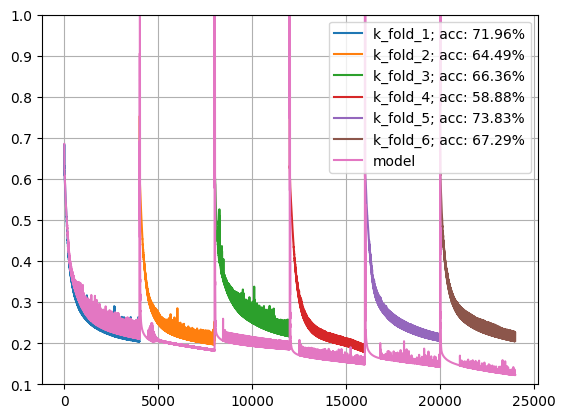

In [63]:
epoch_nn_list = np.arange(1, (num_epoch)*6+1)

for i in range(1, 7):        
    epoch, loss, acc = k_fold_res[f'k_fold_{i}']
    plt.plot(epoch+(i-1)*num_epoch, loss, label=f'k_fold_{i}; acc: {acc:.2f}%')
plt.plot(epoch_nn_list, loss_nn_list, label='model')
plt.ylim(0.1, 1)
plt.grid()
plt.legend()
plt.show()

In [64]:
## Validation loop ##
x_val, y_val = X_Val, Y_Val
test_samples = len(y_val)
with torch.no_grad():
    n_correct_nn = 0
    n_correct_kk = 0
    n_samples = 0

    for i in range(test_samples):
        output_nn = model_nn(x_val[i])
        output_kk= model_k(x_val[i])
        _, predictions_nn = torch.max(output_nn, dim=0)
        _, predictions_kk = torch.max(output_kk, dim=0)
        _, actual      = torch.max(y_val[i], dim=0)
        n_samples += 1
        n_correct_nn += (predictions_nn == actual).sum()
        n_correct_kk += (predictions_kk == actual).sum()

    
    test_acc_nn = 100*n_correct_nn/n_samples
    test_acc_kk = 100*n_correct_kk/n_samples
    
    print(f'Validation Set\nacc_nn = {test_acc:.5f}%')
    print(f'acc_kk = {test_acc:.5f}%')

## Entire dataset loop ##
x_val, y_val = X_data, Y_data
test_samples = len(y_val)
with torch.no_grad():
    n_correct = 0
    n_samples = 0

    for i in range(test_samples):
        output = model_nn(x_val[i])
        _, predictions = torch.max(output, dim=0)
        _, actual      = torch.max(y_val[i], dim=0)
        n_samples += 1
        n_correct += (predictions == actual).sum()

    
    test_acc = 100*n_correct/n_samples
    
    print(f'\nEntire Dataset\nacc = {test_acc:.5f}%')

Validation Set
acc_nn = 67.28972%
acc_kk = 67.28972%

Entire Dataset
acc = 88.51540%


### Sklearn models

Acc: 0.8055555555555556
Rec: 0.6967741935483871
Pre: 0.8244274809160306
Spe: 0.8244274809160306
F1 : 0.7552447552447553


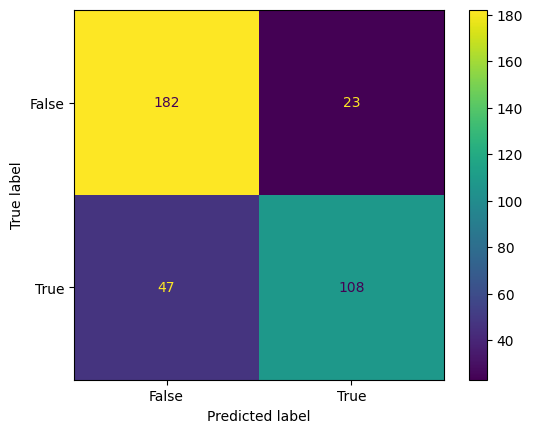

In [58]:
RFC = sklearn.ensemble.RandomForestClassifier

model = RFC(n_estimators=50, max_depth=20, random_state=1)
model.fit(xTrainC, yTrainC[:,1])
y_pred = model.predict(xTestC)

accScore = metrics.accuracy_score(yTestC[:,1], y_pred); print(f"Acc: {accScore}")
recScore = metrics.recall_score(yTestC[:,1], y_pred); print(f"Rec: {recScore}")
preScore = metrics.precision_score(yTestC[:,1], y_pred); print(f"Pre: {preScore}")
speScore = metrics.precision_score(yTestC[:,1], y_pred); print(f"Spe: {speScore}")
F1_Score = metrics.f1_score(yTestC[:,1], y_pred); print(f"F1 : {F1_Score}")


confMat = metrics.confusion_matrix(yTestC[:,1], y_pred)
CM_disp = metrics.ConfusionMatrixDisplay(confusion_matrix=confMat, display_labels=[False, True])
CM_disp.plot()
plt.show()


Acc: 0.6222222222222222
Rec: 0.14193548387096774
Pre: 0.88
Spe: 0.88
F1 : 0.24444444444444446


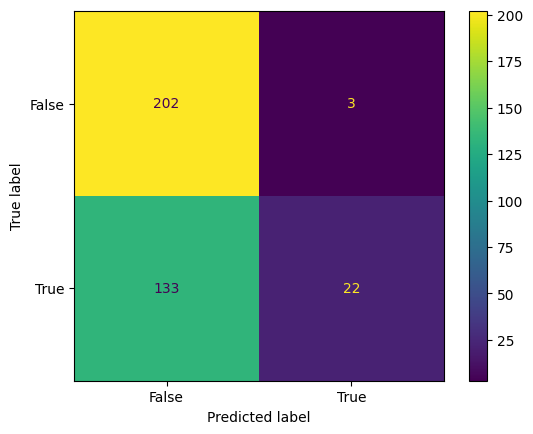

In [50]:
model_svm = svm.SVC(kernel='poly', degree=6)
model_svm.fit(xTrainC, yTrainC[:,1])
y_pred = model_svm.predict(xTestC)

accScore = metrics.accuracy_score(yTestC[:,1], y_pred); print(f"Acc: {accScore}")
recScore = metrics.recall_score(yTestC[:,1], y_pred); print(f"Rec: {recScore}")
preScore = metrics.precision_score(yTestC[:,1], y_pred); print(f"Pre: {preScore}")
speScore = metrics.precision_score(yTestC[:,1], y_pred); print(f"Spe: {speScore}")
F1_Score = metrics.f1_score(yTestC[:,1], y_pred); print(f"F1 : {F1_Score}")


confMat = metrics.confusion_matrix(yTestC[:,1], y_pred)
CM_disp = metrics.ConfusionMatrixDisplay(confusion_matrix=confMat, display_labels=[False, True])
CM_disp.plot()
plt.show()

Acc: 0.6638888888888889
Rec: 0.4129032258064516
Pre: 0.6808510638297872
Spe: 0.6808510638297872
F1 : 0.5140562248995983


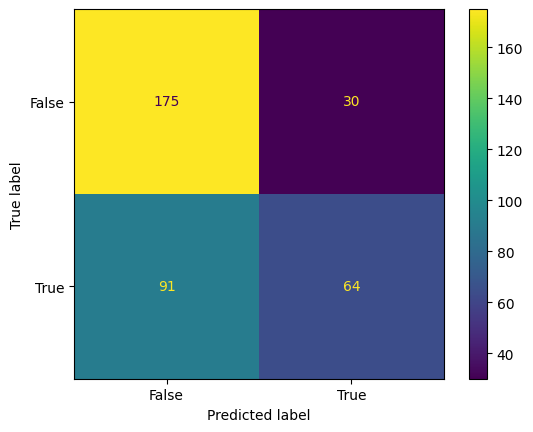

In [51]:
model_KNC = sklearn.neighbors.NearestCentroid()
model_KNC.fit(xTrainC, yTrainC[:, 1])
y_pred = model_KNC.predict(xTestC)

accScore = metrics.accuracy_score(yTestC[:,1], y_pred); print(f"Acc: {accScore}")
recScore = metrics.recall_score(yTestC[:,1], y_pred); print(f"Rec: {recScore}")
preScore = metrics.precision_score(yTestC[:,1], y_pred); print(f"Pre: {preScore}")
speScore = metrics.precision_score(yTestC[:,1], y_pred); print(f"Spe: {speScore}")
F1_Score = metrics.f1_score(yTestC[:,1], y_pred); print(f"F1 : {F1_Score}")


confMat = metrics.confusion_matrix(yTestC[:,1], y_pred)
CM_disp = metrics.ConfusionMatrixDisplay(confusion_matrix=confMat, display_labels=[False, True])
CM_disp.plot()
plt.show()

Acc: 0.7166666666666667
Rec: 0.5483870967741935
Pre: 0.7264957264957265
Spe: 0.7264957264957265
F1 : 0.6249999999999999


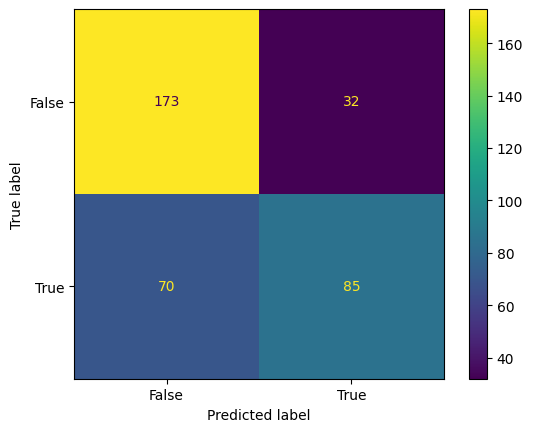

In [52]:
model_knn = sklearn.neighbors.KNeighborsClassifier(n_neighbors=15)
model_knn.fit(xTrainC, yTrainC[:,1])
y_pred = model_knn.predict(xTestC)

accScore = metrics.accuracy_score(yTestC[:,1], y_pred); print(f"Acc: {accScore}")
recScore = metrics.recall_score(yTestC[:,1], y_pred); print(f"Rec: {recScore}")
preScore = metrics.precision_score(yTestC[:,1], y_pred); print(f"Pre: {preScore}")
speScore = metrics.precision_score(yTestC[:,1], y_pred); print(f"Spe: {speScore}")
F1_Score = metrics.f1_score(yTestC[:,1], y_pred); print(f"F1 : {F1_Score}")


confMat = metrics.confusion_matrix(yTestC[:,1], y_pred)
CM_disp = metrics.ConfusionMatrixDisplay(confusion_matrix=confMat, display_labels=[False, True])
CM_disp.plot()
plt.show()

Acc: 0.8111111111111111
Rec: 0.6967741935483871
Pre: 0.8372093023255814
Spe: 0.8372093023255814
F1 : 0.7605633802816901


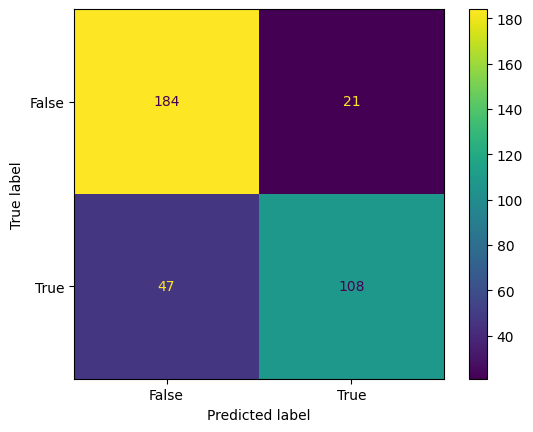

In [103]:
from sklearn.neural_network import MLPClassifier
model_mlp = MLPClassifier(
    solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(20, 6), random_state=1, max_iter=600
)
model_mlp.fit(xTrainC, yTrainC[:,1])
y_pred = model_mlp.predict(xTestC)

accScore = metrics.accuracy_score(yTestC[:,1], y_pred); print(f"Acc: {accScore}")
recScore = metrics.recall_score(yTestC[:,1], y_pred); print(f"Rec: {recScore}")
preScore = metrics.precision_score(yTestC[:,1], y_pred); print(f"Pre: {preScore}")
speScore = metrics.precision_score(yTestC[:,1], y_pred); print(f"Spe: {speScore}")
F1_Score = metrics.f1_score(yTestC[:,1], y_pred); print(f"F1 : {F1_Score}")


confMat = metrics.confusion_matrix(yTestC[:,1], y_pred)
CM_disp = metrics.ConfusionMatrixDisplay(confusion_matrix=confMat, display_labels=[False, True])
CM_disp.plot()
plt.show()